In [1]:
import sys
import yt.units as u
import numpy
import numpy as np
import matplotlib.pyplot as plt
import pyximport

from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import h5py
import os
import numpy
import h5py

os.environ['HDF5_DIR'] = '//anaconda/'

In [2]:
def Init_values(temperature, density, n_species = 9, cooling=True, size=10):
    """ Create a initial value dictionary,
        for a given temperature, density, number of species
    Args:
        temperature -- in Kelvin
        density     -- in amu / cm**3
        n_species   -- number of species (6/9)
        cooling

    Returns:
        init_values: initial value dictionary with
                     self-consistent energy/ electron density
        primordial : chemical_network classes

    """

    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()
    primordial.threebody = 4
    
    if n_species == 9:
        for i in range(22):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass
    else:
        for i in range(6):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass

    # the temperature array required to interpolates the rates
    primordial.init_temperature((1e0, 1e5))

    tiny = 1.0e-10

    # init_array are is in fractional abundances
    init_values = dict()
    density = numpy.array([density])*numpy.ones((size))
    if n_species == 6:
        # 6-species model
        init_values["He_1"]    = density * (1.0 - 0.76)
        init_values["He_2"]    = np.array([tiny])
        init_values["He_3"]    = np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = np.array([tiny]) 
    else:
        # 9-species model
        init_values["He_1"]    = density * (1.0 - 0.76) 
        init_values["He_2"]    = density *np.array([tiny])
        init_values["He_3"]    = density *np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = density *np.array([tiny])

        init_values["H_m0"]    = density *np.array([tiny])
        init_values["H2_1"]    = density *np.array([tiny])
        init_values["H2_2"]    = density *np.array([tiny])

    # now everything in mass density
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)

    num_den = {}
    for sp in primordial.required_species:
        try:
            num_den[sp.name] = init_values[sp.name]/ sp.weight
        except:
            pass

    # set up initial temperatures values used to define ge
    init_values['T'] = numpy.array([temperature])*numpy.ones((size))
    ge_array = numpy.ones((size))
    init_values['ge'] = ge_array
    
    # calculate gammaH2
    
    for i in range(size):
        
        temperature = init_values['T'][i]
        x = 6100.0/temperature
        expx = numpy.exp(x)
        gammaH2 = 2.0 / (5.0 + 2.0*x*x*expx / (expx - 1 )**2.0 ) + 1

        rs = primordial.required_species
        H2_1_sp = list(rs)[0]
        gammaH2 = primordial.species_gamma(H2_1_sp,name=False, temp=True).subs({'T':temperature})

        new_num_den = {}
        for ele in num_den.keys():
            new_num_den[ele] = num_den[ele][i]
        
        gamma_factor = primordial.gamma_factor().subs(new_num_den).subs({'gammaH2_2': gammaH2 ,'gammaH2_1': gammaH2 , 'gamma': 5./3.,'T': temperature })

        ge  = ((temperature *  kboltz) *gamma_factor
                             / (init_values['density'][i] * mh  ))

        
        T = init_values['density']*ge*mh / kboltz / gamma_factor
        init_values['ge'][i] = numpy.float64(ge)
    print(ge)
    if cooling:
        for cooling_action in cooling_registry:
            k = cooling_registry[cooling_action]
            if (k.species).issubset( primordial.required_species ):
                print("adding cooling: {}".format(k.name) )
                primordial.add_cooling(cooling_action)
    return init_values, primordial

In [3]:
def run_network(init_temp, savefig=False, figure_title=""):
    density = 1e14
    initial_temperature = init_temp
    final_time = (1.0 / (u.G * u.mass_hydrogen * u.cm**-3 * density)**0.5).in_cgs().v
    init, primordial = Init_values(initial_temperature, 
                                   density, n_species = 9, 
                                   cooling=False,size=1)
    primordial.stop_time = final_time
    
    #write solver
    solver_name = "dengo_original"
    primordial.write_solver(solver_name, output_dir = ".",
                            solver_template = "be_chem_solve/rates_and_rate_tables",
                            ode_solver_source = "BE_chem_solve.C",
                            init_values=init,
                            input_is_number=False)
    
    pyximport.install(setup_args={"include_dirs":np.get_include()},
                      reload_support=True, inplace=True)
    dengo_run = pyximport.load_module("dengo_original_run",
                                      "dengo_original_solver_run.pyx",
                                       build_inplace = True, 
                                       pyxbuild_dir = "_dengo_temp")
    
    # NOTICE that the input is in units of mass density (amu / cm**3) (amu is atomic mass unit!)
    # while the output is in units of number density (cm**-3)
    # i should fix that later
    final, intermediate = dengo_run.run_dengo_original( init, 1.0e6 )
    
    flag = intermediate['successful']
    time = intermediate['t'][flag]
    plt.figure(figsize=(10,10))
    for sp in sorted(primordial.required_species):
        sp_abundance =  intermediate[sp.name][0][flag]

        plt.loglog(time, sp_abundance, label=sp.name)
        plt.legend()

    plt.xlabel('time ($s$)')
    plt.xlabel('abundance ($cm^{-3}$)')

    plt.show()
    if savefig:
        plt.savefig(figure_title)
    return

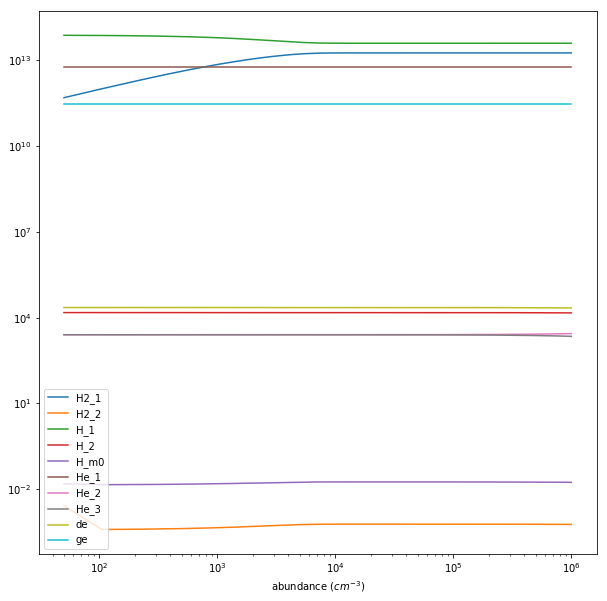

In [37]:
run_network(3000)